
### Анализ аномалий в данных аренды велосипедов Лондона

#### Цель проекта
В рамках данного исследования мы сосредоточимся на обнаружении аномальных значений в данных об аренде велосипедов. 

**Контекст:** Я работаю аналитиком в компании по аренде велосипедов, и коллеги из лондонского офиса предоставили данные за двухлетний период с 4 января 2015 по 3 января 2017 года.

**Основные задачи анализа:**
- Изучить динамику числа аренд велосипедов
- Исследовать влияние погодных условий и выходных дней на популярность аренды
- Выявить и объяснить аномалии, присутствующие на графиках

#### План работы

**1. Первичный анализ данных**
- Загрузка данных и оценка их структуры
- Проверка на наличие пропущенных значений
- Приведение типов данных к корректному формату

**2. Временной анализ**
- Построение графиков динамики аренд по дате и времени
- Агрегация данных по дням для выявления общих тенденций

**3. Выявление аномалий**
- Расчет скользящего среднего для сглаживания временного ряда
- Определение статистических границ для нормальных значений
- Исследование экстремальных значений - как максимальных, так и минимальных

**4. Объяснение аномалий**
- Поиск причин необычно высоких и низких показателей аренды
- Связь аномалий с внешними факторами (погода, праздники, события)

#### Описание данных
В распоряжении имеются следующие переменные:
- `timestamp` - временная метка с точностью до часа
- `cnt` - количество аренд за час
- `t1`, `t2` - фактическая температура и "ощущаемая" температура (°C)
- `hum` - влажность воздуха (%)
- `wind_speed` - скорость ветра (км/ч)
- `weather_code` - код погодных условий (от ясной погоды до снегопада)
- `isholiday`, `isweekend` - индикаторы праздников и выходных
- `season` - метеорологический сезон

Приступаю к поэтапному выполнению анализа...

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### Шаг 1: Первичная загрузка и оценка качества данных

Первым этапом любого анализа является знакомство с данными. Мне необходимо:

- Загрузить dataset и оценить его объем - понять, с каким количеством наблюдений и признаков предстоит работать
- Проверить целостность данных - выявить наличие пропущенных значений, которые могут повлиять на дальнейший анализ
- Убедиться в корректности типов данных - особенно важно для временных меток, чтобы временные ряды строились правильно

Этот этап позволит мне получить первое представление о качестве данных и при необходимости сразу провести их очистку, чтобы обеспечить надежность всех последующих вычислений и визуализаций.

In [13]:
df = pd.read_csv('london.csv')
df.shape


(17414, 10)

In [14]:
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [6]:
df.isna().count()

timestamp       17414
cnt             17414
t1              17414
t2              17414
hum             17414
wind_speed      17414
weather_code    17414
is_holiday      17414
is_weekend      17414
season          17414
dtype: int64

In [9]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [11]:
df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [15]:
df.timestamp = pd.to_datetime(df.timestamp)

In [16]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

### Шаг 2: Визуализация временного ряда аренд

Теперь, когда данные подготовлены, перехожу к первичной визуализации динамики аренд велосипедов. Построение линейного графика позволит мне:

- Оценить общую тенденцию изменения спроса на аренду велосипедов за двухлетний период
- Выявить сезонныеPatternы и циклические колебания
- Заметить потенциальные аномалии - резкие всплески или падения аренд
- Понять, как меняется популярность сервиса с течением времени

Использую точечные данные с часовой детализацией, чтобы получить максимально подробную картину происходящего. Это даст хорошую основу для дальнейшего, более детального анализа.

<Axes: xlabel='timestamp', ylabel='cnt'>

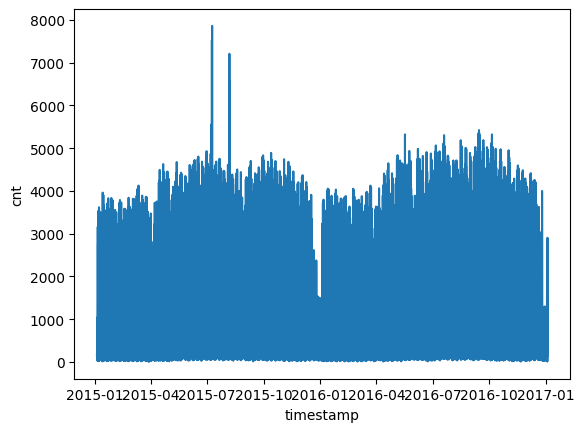

In [18]:
sns.lineplot(data = df,x = 'timestamp',y = 'cnt')

### Шаг 3: Агрегация данных по дням и визуализация

Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды

Мне предстоит:

- Использовать метод `.resample()` для перевода данных из часового формата в дневной
- Просуммировать количество поездок в пределах каждого дня
- Визуализировать полученный ряд данных

Такой подход позволит сгладить часовые колебания и сосредоточиться на более значимых изменениях - недельных ритмах, сезонных трендах и действительно заметных аномалиях, которые могут быть не так очевидны на слишком детализированном графике.

<Axes: xlabel='timestamp', ylabel='cnt'>

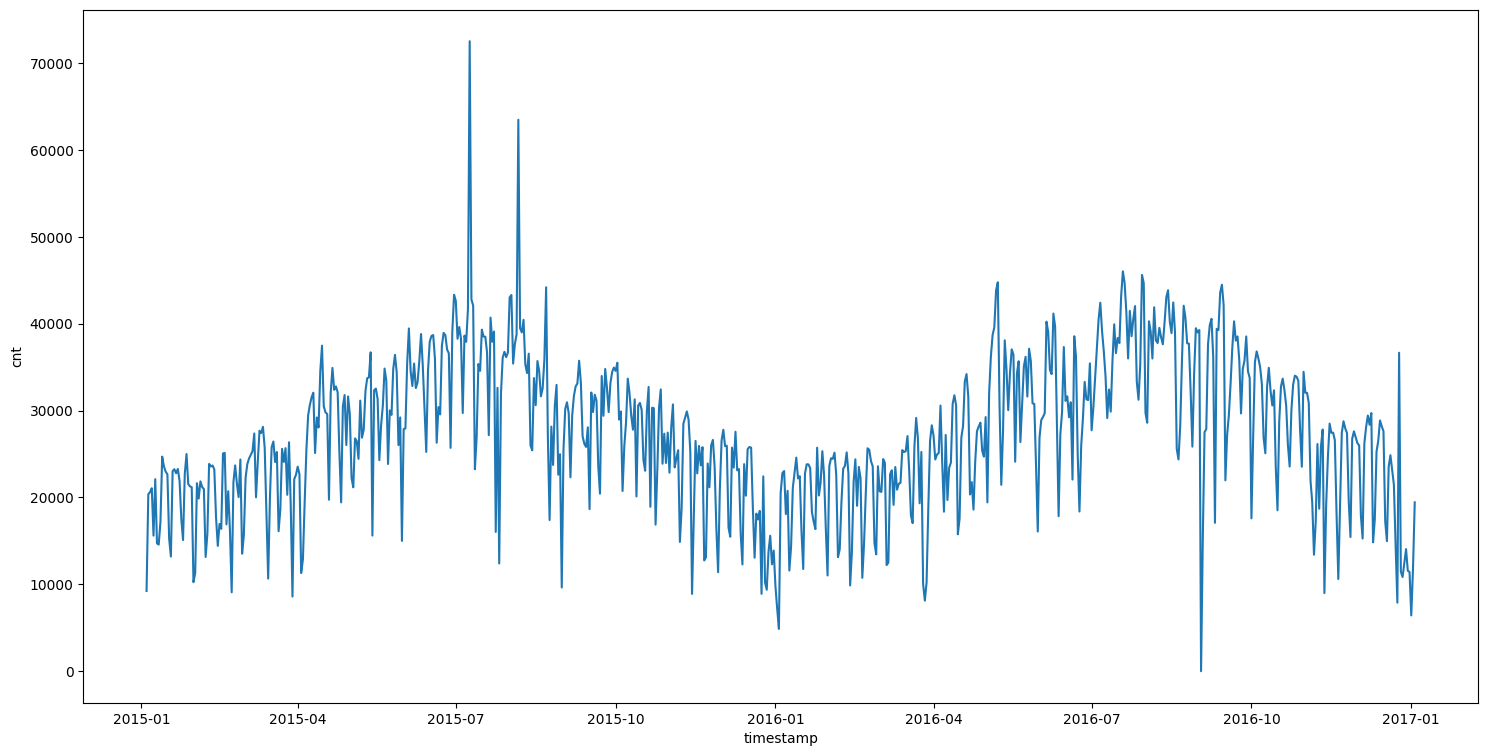

In [27]:
df_with_date_idx = df.set_index('timestamp')
plt.figure(figsize=(18,9))
sns.lineplot(df_with_date_idx.resample(rule='D').cnt.sum())


### Вывод:
- Встречаются как очень резкие скачки числа аренд, так и падения
- Зимой число аренд меньше, чем летом
- Максимальное число аренд за день составляет более 70 000

### Шаг 4: Расчет скользящего среднего для выявления аномалий

Действительно, на предыдущем графике заметны выраженные колебания и скачки. Чтобы объективно оценить, какие из них являются статистически значимыми аномалиями, а какие - частью нормальной динамики, необходимо учесть временную природу данных.

Для этого я использую метод скользящего среднего с окном в 3 дня. Этот подход позволит:

- Сгладить случайные колебания и выделить основную тенденцию
- Учесть краткосрочные зависимости в данных (значения соседних дней часто коррелируют)
- Создать базовую линию для сравнения с фактическими значениями

Окно в 3 дня выбрано как компромисс между достаточным сглаживанием и сохранением чувствительности к реальным изменениям тренда. Полученные значения скользящего среднего станут основой для расчета доверительного интервала на следующем шаге.

In [42]:
s_date_cnt = df_with_date_idx.resample(rule='D').cnt.sum()
df_date_per_cnt = pd.DataFrame(s_date_cnt).reset_index()
df_date_per_cnt

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
726,2016-12-30,11566
727,2016-12-31,11424
728,2017-01-01,6421
729,2017-01-02,11823


In [62]:
df_date_per_cnt['roll'] = df_date_per_cnt.cnt.rolling(window=3).mean()
df_date_per_cnt['diff'] = df_date_per_cnt.cnt-df_date_per_cnt.roll
df_date_per_cnt

,timestamp,cnt,roll,diff,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,20972.823819,-2504.823819
1,2015-01-05,20372,NaN,NaN,26541.823819,3064.176181
2,2015-01-06,20613,16739.666667,3873.333333,28478.490486,5000.842847
3,2015-01-07,21064,20683.000000,381.000000,32421.823819,8944.176181
4,2015-01-08,15601,19092.666667,-3491.666667,30831.490486,7353.842847
...,...,...,...,...,...,...
726,2016-12-30,11566,12682.000000,-1116.000000,24420.823819,943.176181
727,2016-12-31,11424,12347.333333,-923.333333,24086.157153,608.509514
728,2017-01-01,6421,9803.666667,-3382.666667,21542.490486,-1935.157153
729,2017-01-02,11823,9889.333333,1933.666667,21628.157153,-1849.490486


### Шаг 5: Анализ отклонений от тренда

Теперь, когда у нас есть сглаженный ряд скользящего среднего, представляющий основную тенденцию, важно количественно оценить величину отклонений фактических значений от этого тренда.

Мне предстоит:
- Рассчитать разницу между наблюдаемым количеством аренд и значениями скользящего среднего
- Вычислить стандартное отклонение этих отклонений, чтобы понять типичный разброс значений вокруг тренда

Стандартное отклонение с параметром `ddof=0` (дельта степеней свободы = 0) будет рассчитываться как стандартное отклонение генеральной совокупности, что корректно для нашего полного набора отклонений. Эта метрика станет ключевой для определения границ "нормального" колебания и последующего выявления статистически значимых аномалий.

In [63]:
std = np.std(df_date_per_cnt['diff'],ddof=0)
std

4558.586641117938

### Шаг 6: Определение границ аномальных значений

На основе рассчитанного стандартного отклонения я могу теперь определить статистические границы для выявления аномалий. Использование множителя 2.576 соответствует 99% доверительному интервалу в нормальном распределении, что позволит нам выделить наиболее значимые отклонения.

Мне нужно создать:
- **Верхнюю границу** (upper_bound): скользящее среднее + 2.576 × стандартное отклонение
- **Нижнюю границу** (lower_bound): скользящее среднее - 2.576 × стандартное отклонение

Добавление этих границ в датафрейм в виде отдельных столбцов значительно упростит последующий анализ - я смогу легко фильтровать и визуализировать дни, где фактические значения аренд выходят за установленные пределы, что и будет считаться статистически значимыми аномалиями.

In [64]:
df_date_per_cnt['upper_bound'] = df_date_per_cnt.roll+2.576*std
df_date_per_cnt['lower_bound'] = df_date_per_cnt.roll-2.576*std
df_date_per_cnt

,timestamp,cnt,roll,diff,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333,28482.585854,4996.747479
3,2015-01-07,21064,20683.000000,381.000000,32425.919188,8940.080812
4,2015-01-08,15601,19092.666667,-3491.666667,30835.585854,7349.747479
...,...,...,...,...,...,...
726,2016-12-30,11566,12682.000000,-1116.000000,24424.919188,939.080812
727,2016-12-31,11424,12347.333333,-923.333333,24090.252521,604.414146
728,2017-01-01,6421,9803.666667,-3382.666667,21546.585854,-1939.252521
729,2017-01-02,11823,9889.333333,1933.666667,21632.252521,-1853.585854


### Шаг 7: Анализ аномально высоких значений

Теперь переходим к самому интересному - исследованию выбросов. На этом этапе я сосредоточусь на аномально высоких значениях аренд, которые превысили верхнюю границу 99% доверительного интервала.

Мне необходимо:
- Отфильтровать датафрейм, оставив только те дни, когда фактическое количество аренд превысило расчетную верхнюю границу
- Внимательно изучить полученные аномальные наблюдения
- Определить день с максимальным количеством аренд среди всех аномалий

Эти дни представляют особый интерес - такие всплески активности обычно связаны с конкретными событиями, погодными аномалиями или другими внешними факторами, которые нам предстоит выяснить.


In [65]:
df_date_per_cnt[df_date_per_cnt.cnt>df_date_per_cnt.upper_bound]

,timestamp,cnt,roll,diff,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479


 Наиболее вероятной причиной резкого скачка аренд велосипедов 9 июля 2015 года стала масштабная забастовка в лондонском метро. В условиях остановки работы метрополитена жители города были вынуждены искать альтернативные способы передвижения, что привело к взрывному росту спроса на аренду велосипедов.

Это классический пример того, как внешние события могут значительно влиять на поведенческие паттерны пользователей сервиса.

### Шаг 9: Анализ аномально низких значений аренд

После исследования экстремально высоких показателей логично перейти к противоположному явлению - дням с аномально низким количеством аренд. Эти случаи также требуют тщательного изучения, поскольку могут указывать на серьезные проблемы или внешние факторы, негативно влияющие на сервис.

Сосредоточиться на наиболее выраженной аномалии - 2 сентября 2016 года


In [66]:
df_date_per_cnt[df_date_per_cnt.cnt<df_date_per_cnt.lower_bound]

,timestamp,cnt,roll,diff,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
621,2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812


**Вывод:** Наиболее вероятное объяснение нулевого значения - технический сбой или отсутствие записи данных за этот период. В отличие от предыдущей аномалии, где наблюдался всплеск активности из-за внешних событий, здесь мы видим скорее проблему с сбором или сохранением данных, чем реальное отсутствие спроса на аренду велосипедов.